# Config

In [1]:
"""
This notebook estimates the distribution of AI chips (H100-equivalents and TPUs)
across major tech companies based on NVIDIA revenue data and other information.

"""

# Install required packages
!pip install squigglepy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [2]:
# Squigglepy documentation: https://github.com/rethinkpriorities/squigglepy
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B
from pprint import pprint
import pandas as pd

sq.set_seed(42)
np.random.seed(42)

In [3]:
# Helper Functions
# ================

from scipy import stats

# alternative to squigglepy
def generate_lognormal_from_percentiles(x_lower, x_upper, p_lower, p_upper, n=10000):
    """
    Generate lognormal distribution samples from percentile constraints.

    Args:
        x_lower: Lower bound value at p_lower percentile
        x_upper: Upper bound value at p_upper percentile
        p_lower: Lower percentile (e.g., 20 for 20th percentile)
        p_upper: Upper percentile (e.g., 80 for 80th percentile)
        n: Number of samples to generate

    Returns:
        numpy array of lognormal samples
    """
    z_lower = stats.norm.ppf(p_lower / 100)
    z_upper = stats.norm.ppf(p_upper / 100)

    mu = (np.log(x_lower) * z_upper - np.log(x_upper) * z_lower) / (z_upper - z_lower)
    sigma = (np.log(x_upper) - np.log(x_lower)) / (z_upper - z_lower)

    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# wrapper for sq.to, with default credibility of 80% (library default is 90)
def sq_distribution(x_lower, x_upper, credibility=80, lclip = None, rclip = None):
    return sq.to(x_lower, x_upper, credibility, lclip, rclip)


def print_percentile_results(samples, title="Percentiles", percentiles=[25, 50, 75]):
    """Print formatted percentile results."""
    results = sq.get_percentiles(samples, percentiles=percentiles, digits=0)

    print(f"{title}:")
    for percentile, value in results.items():
        print(f"  {percentile}: {value:,}")

    return results


def fy_to_decimal_year(fy_string):
    """
    Convert Nvidia fiscal year quarter string to decimal year.

    Nvidia's fiscal year ends in January, so:
    - FY26 Q1 ends April 2025 (Q1: Feb-Apr)
    - FY26 Q2 ends July 2025 (Q2: May-Jul)
    - FY26 Q3 ends October 2025 (Q3: Aug-Oct)
    - FY26 Q4 ends January 2026 (Q4: Nov-Jan)

    Args:
        fy_string (str): Fiscal year string like "FY23Q1" or "FY26Q2"

    Returns:
        float: Decimal year representing the end date of the quarter

    """
    # Parse the fiscal year and quarter
    fy_part = fy_string[:4]  # "FY26"
    q_part = fy_string[4:]   # "Q1"

    # Extract fiscal year number (last 2 digits)
    fy_num = int(fy_part[2:])

    # Convert 2-digit year to 4-digit year
    # Assuming fiscal years 00-99 map to 2000-2099
    if fy_num < 50:  # Adjust this threshold as needed
        fiscal_year = 2000 + fy_num
    else:
        fiscal_year = 1900 + fy_num

    # Extract quarter number
    quarter = int(q_part[1:])

    # Map quarters to their end months and approximate decimal positions
    quarter_end_map = {
        1: (4, 0.32),   # Q1 ends in April (4/12 ≈ 0.32)
        2: (7, 0.57),   # Q2 ends in July (7/12 ≈ 0.57)
        3: (10, 0.82),  # Q3 ends in October (10/12 ≈ 0.82)
        4: (1, 0.07)    # Q4 ends in January of next calendar year
    }

    end_month, decimal_fraction = quarter_end_map[quarter]

    # For Q4, the calendar year is the fiscal year
    # For Q1-Q3, the calendar year is fiscal year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1

    return calendar_year + decimal_fraction




# Background Chips Data

In [4]:
# Chip performance in 16-bit TFLOP/s without sparsity
CHIP_FLOPS = {
    'A100': 312,
    'H100': 989,
    'H100/H200': 989,
    'H20': 148,       
    'B200': 2500,
    'B300': 2500,     
    'TPUv3': 123,
    'TPUv4': 275,
    'TPUv4i': 138,
    'TPUv5e': 197,
    'TPUv5p': 459,
}

# Nvidia total sales

In [5]:
CHIP_TYPES = ['A100', 'H100/H200', 'H20', 'B200', 'B300']

CHIP_ECONOMICS = {
    # What share of Nvidia's "compute" revenue is actual compute hardware, vs
    # cloud compute or software products
    'hardware_share_of_compute': (0.96, 0.99),

    # Average sale price (thousands USD)
    'H100/H200_price_range': (22, 37),
    'A100_price_range': (10, 15),
    'H20_price_range': (12, 15),
    'B200_price_range': (35, 45),
    'B300_price_range': (35, 45),

    # Nvidia datacenter revenue as share of total revenue, on average
    'dc_share_of_total_revenue': 0.85,
}

def convert_to_h100_equivs(chip_type, quantity):
  return quantity * (CHIP_FLOPS[chip_type] / CHIP_FLOPS['H100/H200'])

In [6]:
# source-of-truth spreadsheet here:
csv_url = "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
chip_prices_df = pd.read_csv(csv_url).set_index('Year')

chip_prices_df.head()

,A100 low,A100 high,Notes,H100 low,H100 high,Geomean,Notes.1,B200 low,B200 high,Geomean.1,Notes.2,B300 low,B300 high,Geomean.2,Notes.3,H20 low,H20 high,Geomean.3
Year,,,,,,,,,,,,,,,,,,
2022,10000,20000,A100 is stub and to-do,30000,45000,"$36,742",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,10000,15000,NaN,30000,40000,"$34,641",server price ~34k in May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,10000,15000,NaN,23000,30000,"$26,268",reportedly sold for 20-23k in late 2024. serve...,35000.0,45000.0,"$39,686",NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,"$12,247"
2025,10000,15000,NaN,20000,27000,"$23,238",NaN,35000.0,45000.0,"$39,686",NaN,40000.0,50000.0,"$44,721","Stub, todo",10000.0,13000.0,"$11,402"


In [7]:
nvda_revenue_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0").set_index('Quarter')

nvda_revenue_df.head(5)

,Start Date,End Date,total_revenue,dc_revenue,dc_share,network_revenue,compute_share_of_dc,compute_revenue,A100,H100/H200,H20,B200,B300,Notes,Press release,CFO commentary link
Quarter,,,,,,,,,,,,,,,,
FY23Q1,2022-01-31,2022-05-01,8.29,3.75,0.452,NaN,0.750,2.81,1.0,0.0,0.0,0.0,0.0,All total revenue figures from Nvidia quarterl...,https://nvidianews.nvidia.com/news/nvidia-anno...,NaN
FY23Q2,2022-05-02,2022-07-31,6.70,3.81,0.569,NaN,0.750,2.86,1.0,0.0,0.0,0.0,0.0,Note that all rows ignore lower-grade data cen...,https://nvidianews.nvidia.com/news/nvidia-anno...,NaN
FY23Q3,2022-08-01,2022-10-30,5.93,3.83,0.646,NaN,0.750,2.87,0.9,0.1,0.0,0.0,0.0,"""Started shipping flagship H100 "" https://s201...",https://nvidianews.nvidia.com/news/nvidia-anno...,NaN
FY23Q4,2022-10-31,2023-01-29,6.05,3.62,0.598,NaN,0.750,2.72,0.4,0.6,0.0,0.0,0.0,"""H100 revenue was already much higher than tha...",https://investor.nvidia.com/news/press-release...,NaN
FY24Q1,2023-01-30,2023-04-30,7.19,4.28,0.595,0.927,0.783,3.35,0.2,0.8,0.0,0.0,0.0,NaN,https://investor.nvidia.com/news/press-release...,NaN


In [8]:
# NVIDIA Chip Sales Analysis
# ==========================

# Calculate revenue by chip type

quarterly_revenue_df = nvda_revenue_df


revenue_totals = {}

# Uncertainty distribution for what share of compute revenue is actually hardware
hardware_share = sq_distribution(*CHIP_ECONOMICS['hardware_share_of_compute'])

# find quarterly revenue by chip 
for chip_type in CHIP_TYPES:
    quarterly_revenue_df[f'{chip_type}_revenue'] = quarterly_revenue_df['compute_revenue'] * quarterly_revenue_df[chip_type]
    revenue_totals[chip_type] = quarterly_revenue_df[f'{chip_type}_revenue'].sum()

print("Total NVIDIA Revenue by Chip Type (Billions USD):")
for chip_type, revenue in revenue_totals.items():
    if revenue > 0:
        print(f"  {chip_type}: ${revenue:.1f}B")

# Helper function to get dynamic price distribution based on year
def get_dynamic_price_distribution(chip_type, year):
    """Get price distribution for a specific chip type and year from chip_economics_df"""
    # Find the closest year in chip_prices_df
    available_years = chip_prices_df.index.tolist()
    closest_year = min(available_years, key=lambda x: abs(x - year))

    # Get the low and high prices for this chip type and year
    low_col = f'{chip_type} low'
    high_col = f'{chip_type} high'

    if (low_col in chip_prices_df.columns and high_col in chip_prices_df.columns):
        low_price = chip_prices_df.loc[closest_year, low_col]
        high_price = chip_prices_df.loc[closest_year, high_col]

        if not (pd.isna(low_price) or pd.isna(high_price)):
            # Create price distribution using the low and high values
            return sq_distribution(low_price, high_price)

    # Fallback to static pricing if quarterly prices aren't available
    fallback_prices = CHIP_ECONOMICS[f'{chip_type}_price_range']

    return sq_distribution(*[x * K for x in fallback_prices])

# Calculate chip sales by type using dynamic pricing over quarters
chip_sales = {}
h100_equiv_sales = {}

# Initialize accumulated sales distributions
for chip_type in CHIP_TYPES:
    chip_sales[chip_type] = 0
    h100_equiv_sales[chip_type] = 0

# df of quarterly sales by chip type
quarterly_chip_sales = pd.DataFrame(index=quarterly_revenue_df.index)

# Process each quarter with time-specific pricing
for quarter in quarterly_revenue_df.index:
    # Get the year for this quarter using the helper function
    quarter_year = int(round(fy_to_decimal_year(quarter)))

    for chip_type in CHIP_TYPES:
        quarterly_revenue_for_chip = quarterly_revenue_df.loc[quarter, f'{chip_type}_revenue'] * B  # Convert to dollars

        if quarterly_revenue_for_chip > 0:
            # Get dynamic price distribution for this quarter and chip type
            price_dist = get_dynamic_price_distribution(chip_type, quarter_year)

            # Calculate number of this chip type sold
            quarterly_sales = quarterly_revenue_for_chip * hardware_share / price_dist

            # Calculate H100-equivalent sales
            if chip_type == 'A100':
                quarterly_equiv_sales = quarterly_sales * (CHIP_FLOPS['A100'] / CHIP_FLOPS['H100/H200'])
            elif chip_type == 'H100/H200':
                quarterly_equiv_sales = quarterly_sales  # Baseline
            elif chip_type == 'H20':
                quarterly_equiv_sales = quarterly_sales * (CHIP_FLOPS['H20'] / CHIP_FLOPS['H100/H200'])
            elif chip_type == 'B200':
                quarterly_equiv_sales = quarterly_sales * (CHIP_FLOPS['B200'] / CHIP_FLOPS['H100/H200'])

            # Accumulate sales across quarters
            chip_sales[chip_type] += quarterly_sales
            h100_equiv_sales[chip_type] += quarterly_equiv_sales

# Calculate total H100-equivalent sales
total_h100_equivs = sum(h100_equiv_sales.values())
total_samples = total_h100_equivs @ 10000

print(f"\nNVIDIA Total H100-Equivalent Sales:")
nvidia_results = print_percentile_results(total_samples, "", [10, 50, 90])

for chip in CHIP_TYPES:
    chip_samples = h100_equiv_sales[chip] @ 10000
    print_percentile_results(chip_samples, f'Total sales of {chip} in H100-equivalents', [10, 50, 90])

Total NVIDIA Revenue by Chip Type (Billions USD):
  A100: $11.5B
  H100/H200: $129.0B
  H20: $20.5B
  B200: $61.1B
  B300: $41.5B

NVIDIA Total H100-Equivalent Sales:
:
  10: 10,011,309
  50: 10,492,548
  90: 11,023,340
Total sales of A100 in H100-equivalents:
  10: 253,758
  50: 281,814
  90: 314,342
Total sales of H100/H200 in H100-equivalents:
  10: 4,102,572
  50: 4,478,256
  90: 4,918,715
Total sales of H20 in H100-equivalents:
  10: 244,908
  50: 260,383
  90: 276,983
Total sales of B200 in H100-equivalents:
  10: 3,559,120
  50: 3,806,524
  90: 4,073,790
Total sales of B300 in H100-equivalents:
  10: 1,504,962
  50: 1,648,024
  90: 1,801,053


In [9]:
# Quarterly Chip Sales Analysis
# =============================

# Calculate quarterly chip quantities with price distributions
quarterly_chip_quantities = pd.DataFrame(index=quarterly_revenue_df.index)

# Add decimal year column for easier analysis
quarterly_chip_quantities['decimal_year'] = [fy_to_decimal_year(quarter) for quarter in quarterly_revenue_df.index]

# Calculate quarterly quantities for each chip type
for chip_type in CHIP_TYPES:

    # Calculate quarterly revenue for this chip type
    quarterly_revenue = quarterly_revenue_df[f'{chip_type}_revenue'] * B  # Convert to dollars

    # Calculate quarterly chip quantities (accounting for price distributions)
    for quarter in quarterly_revenue_df.index:
        year = fy_to_decimal_year(quarter)
        price_dist = get_dynamic_price_distribution(chip_type, year)

        if quarterly_revenue[quarter] > 0:
            quarter_revenue = quarterly_revenue[quarter]
            quarter_quantity = quarter_revenue * hardware_share / price_dist

            # Store the distribution for sampling
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = quarter_quantity

            # Calculate median for display
            samples = quarter_quantity @ 1000
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = np.median(samples)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_10th'] = np.percentile(samples, 10)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = np.percentile(samples, 25)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = np.percentile(samples, 75)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_90th'] = np.percentile(samples, 90)
        else:
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = None
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_10th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_90th'] = 0

print("Quarterly Chip Quantities (Median Estimates):")
print("=" * 50)

# Display quarterly quantities for each chip type
for chip_type in CHIP_TYPES:
    print(f"\n{chip_type} Quarterly Sales:")
    for quarter in quarterly_revenue_df.index:
        median_qty = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median']
        if median_qty > 0:
            p25 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th']
            p75 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th']
            year = quarterly_chip_quantities.loc[quarter, 'decimal_year']
            print(f"  {quarter} ({year:.1f}): {median_qty:,.0f} chips (25th-75th: {p25:,.0f} - {p75:,.0f})")

# Create summary dataframe with median and percentile values
quarterly_sales = pd.DataFrame(index=quarterly_chip_quantities.index)
quarterly_sales['decimal_year'] = quarterly_chip_quantities['decimal_year']

# Add median, 10th and 90th percentiles for each chip type
for chip in CHIP_TYPES:
    quarterly_sales[f'{chip}_quantity'] = quarterly_chip_quantities[f'{chip}_quantity_median']
    quarterly_sales[f'{chip}_quantity_10th'] = quarterly_chip_quantities[f'{chip}_quantity_10th']
    quarterly_sales[f'{chip}_quantity_90th'] = quarterly_chip_quantities[f'{chip}_quantity_90th']

print(f"\nQuarterly Summary DataFrame:")
print(quarterly_sales[['decimal_year'] + [f'{chip}_quantity' for chip in CHIP_TYPES]].round(0))

Quarterly Chip Quantities (Median Estimates):

A100 Quarterly Sales:
  FY23Q1 (2022.3): 193,671 chips (25th-75th: 160,883 - 233,270)
  FY23Q2 (2022.6): 226,367 chips (25th-75th: 205,684 - 250,163)
  FY23Q3 (2022.8): 205,169 chips (25th-75th: 184,905 - 230,175)
  FY23Q4 (2023.1): 85,807 chips (25th-75th: 77,681 - 96,563)
  FY24Q1 (2023.3): 53,275 chips (25th-75th: 47,685 - 59,916)
  FY24Q2 (2023.6): 68,752 chips (25th-75th: 61,781 - 75,793)
  FY24Q3 (2023.8): 47,593 chips (25th-75th: 42,375 - 52,849)

H100/H200 Quarterly Sales:
  FY23Q3 (2022.8): 9,791 chips (25th-75th: 8,567 - 11,252)
  FY23Q4 (2023.1): 55,597 chips (25th-75th: 48,232 - 64,133)
  FY24Q1 (2023.3): 91,936 chips (25th-75th: 80,481 - 105,277)
  FY24Q2 (2023.6): 268,324 chips (25th-75th: 231,352 - 308,058)
  FY24Q3 (2023.8): 380,816 chips (25th-75th: 335,454 - 443,119)
  FY24Q4 (2024.1): 512,460 chips (25th-75th: 446,054 - 594,477)
  FY25Q1 (2024.3): 572,493 chips (25th-75th: 496,856 - 649,027)
  FY25Q2 (2024.6): 658,466 ch

In [10]:
quarterly_chip_quantities.head(5)

,decimal_year,A100_quantity_dist,A100_quantity_median,A100_quantity_10th,A100_quantity_25th,A100_quantity_75th,A100_quantity_90th,H100/H200_quantity_dist,H100/H200_quantity_median,H100/H200_quantity_10th,...,B200_quantity_10th,B200_quantity_25th,B200_quantity_75th,B200_quantity_90th,B300_quantity_dist,B300_quantity_median,B300_quantity_10th,B300_quantity_25th,B300_quantity_75th,B300_quantity_90th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,<Distribution> 2810000000.0 * lognorm(lognorm_...,193671.484336,136562.807828,160882.894936,233270.113863,278592.611583,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q2,2022.57,<Distribution> 2860000000.0 * lognorm(lognorm_...,226367.054597,187939.791231,205684.347103,250163.272882,275283.054849,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q3,2022.82,<Distribution> 2583000000.0 * lognorm(lognorm_...,205168.919657,167484.573153,184905.448179,230175.436722,254123.792280,<Distribution> 287000000.00000006 * lognorm(lo...,9790.992816,7583.724825,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q4,2023.07,<Distribution> 1088000000.0 * lognorm(lognorm_...,85806.945840,70533.867772,77681.364327,96562.939990,105914.248159,<Distribution> 1632000000.0 * lognorm(lognorm_...,55596.819262,42715.766814,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY24Q1,2023.32,<Distribution> 670000000.0 * lognorm(lognorm_m...,53275.451310,43797.663074,47684.984300,59916.334086,65365.945631,<Distribution> 2680000000.0 * lognorm(lognorm_...,91935.973304,71568.105315,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0


In [11]:
quarterly_sales.head(5)

,decimal_year,A100_quantity,A100_quantity_10th,A100_quantity_90th,H100/H200_quantity,H100/H200_quantity_10th,H100/H200_quantity_90th,H20_quantity,H20_quantity_10th,H20_quantity_90th,B200_quantity,B200_quantity_10th,B200_quantity_90th,B300_quantity,B300_quantity_10th,B300_quantity_90th
Quarter,,,,,,,,,,,,,,,,
FY23Q1,2022.32,193671.484336,136562.807828,278592.611583,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q2,2022.57,226367.054597,187939.791231,275283.054849,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q3,2022.82,205168.919657,167484.573153,254123.792280,9790.992816,7583.724825,12790.621100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q4,2023.07,85806.945840,70533.867772,105914.248159,55596.819262,42715.766814,72846.326122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY24Q1,2023.32,53275.451310,43797.663074,65365.945631,91935.973304,71568.105315,118152.242883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Nvidia sales by chip type

In [12]:
# Calculate total H100-equivalent chips per quarter
# Convert quarterly median quantities to H100 equivalents

# Calculate H100 equivalents for each chip type and sum them up
quarterly_sales['Total_H100_equiv'] = (
    convert_to_h100_equivs('A100', quarterly_sales['A100_quantity']) +
    quarterly_sales['H100/H200_quantity'] +
    convert_to_h100_equivs('H20', quarterly_sales['H20_quantity']) +
    convert_to_h100_equivs('B200', quarterly_sales['B200_quantity']) +
    convert_to_h100_equivs('B300', quarterly_sales['B300_quantity'])
)

quarterly_sales['Total_A100_in_H100e'] = convert_to_h100_equivs('A100', quarterly_sales['A100_quantity'])
quarterly_sales['Total_H20_in_H100e'] = convert_to_h100_equivs('H20', quarterly_sales['H20_quantity'])
quarterly_sales['Total_B200_in_H100e'] = convert_to_h100_equivs('B200', quarterly_sales['B200_quantity'])
quarterly_sales['Total_B300_in_H100e'] = convert_to_h100_equivs('B300', quarterly_sales['B300_quantity'])
# Calculate H100e for 10th and 90th percentiles
quarterly_sales['Total_H100_equiv_10th'] = (
    convert_to_h100_equivs('A100', quarterly_sales['A100_quantity_10th']) +
    quarterly_sales['H100/H200_quantity_10th'] +
    convert_to_h100_equivs('H20', quarterly_sales['H20_quantity_10th']) +
    convert_to_h100_equivs('B200', quarterly_sales['B200_quantity_10th']) +
    convert_to_h100_equivs('B300', quarterly_sales['B300_quantity_10th'])
)

quarterly_sales['Total_H100_equiv_90th'] = (
    convert_to_h100_equivs('A100', quarterly_sales['A100_quantity_90th']) +
    quarterly_sales['H100/H200_quantity_90th'] +
    convert_to_h100_equivs('H20', quarterly_sales['H20_quantity_90th']) +
    convert_to_h100_equivs('B200', quarterly_sales['B200_quantity_90th']) +
    convert_to_h100_equivs('B300', quarterly_sales['B300_quantity_90th'])
)

quarterly_sales['Total_A100_in_H100e_10th'] = convert_to_h100_equivs('A100', quarterly_sales['A100_quantity_10th'])
quarterly_sales['Total_A100_in_H100e_90th'] = convert_to_h100_equivs('A100', quarterly_sales['A100_quantity_90th'])
quarterly_sales['Total_H20_in_H100e_10th'] = convert_to_h100_equivs('H20', quarterly_sales['H20_quantity_10th'])
quarterly_sales['Total_H20_in_H100e_90th'] = convert_to_h100_equivs('H20', quarterly_sales['H20_quantity_90th'])
quarterly_sales['Total_B200_in_H100e_10th'] = convert_to_h100_equivs('B200', quarterly_sales['B200_quantity_10th'])
quarterly_sales['Total_B200_in_H100e_90th'] = convert_to_h100_equivs('B200', quarterly_sales['B200_quantity_90th'])
quarterly_sales['Total_B300_in_H100e_10th'] = convert_to_h100_equivs('B300', quarterly_sales['B300_quantity_10th'])
quarterly_sales['Total_B300_in_H100e_90th'] = convert_to_h100_equivs('B300', quarterly_sales['B300_quantity_90th'])
# For H100/H200, the H100e value is the same as quantity (H100 is the reference unit)
quarterly_sales['Total_H100_in_H100e'] = quarterly_sales['H100/H200_quantity']
quarterly_sales['Total_H100_in_H100e_10th'] = quarterly_sales['H100/H200_quantity_10th']
quarterly_sales['Total_H100_in_H100e_90th'] = quarterly_sales['H100/H200_quantity_90th']



print("Quarterly Summary with Total H100-Equivalent Chips:")
print(quarterly_sales.round(1))

Quarterly Summary with Total H100-Equivalent Chips:
         decimal_year  A100_quantity  A100_quantity_10th  A100_quantity_90th  \
Quarter                                                                        
FY23Q1         2022.3       193671.5            136562.8            278592.6   
FY23Q2         2022.6       226367.1            187939.8            275283.1   
FY23Q3         2022.8       205168.9            167484.6            254123.8   
FY23Q4         2023.1        85806.9             70533.9            105914.2   
FY24Q1         2023.3        53275.5             43797.7             65365.9   
FY24Q2         2023.6        68752.2             55428.9             84619.7   
FY24Q3         2023.8        47592.8             38794.1             58150.1   
FY24Q4         2024.1            0.0                 0.0                 0.0   
FY25Q1         2024.3            0.0                 0.0                 0.0   
FY25Q2         2024.6            0.0                 0.0            

In [13]:
quarterly_sales.head(25)

,decimal_year,A100_quantity,A100_quantity_10th,A100_quantity_90th,H100/H200_quantity,H100/H200_quantity_10th,H100/H200_quantity_90th,H20_quantity,H20_quantity_10th,H20_quantity_90th,...,Total_H100_equiv_10th,Total_H100_equiv_90th,Total_A100_in_H100e_10th,Total_A100_in_H100e_90th,Total_H20_in_H100e_10th,Total_H20_in_H100e_90th,Total_B200_in_H100e_10th,Total_B200_in_H100e_90th,Total_B300_in_H100e_10th,Total_B300_in_H100e_90th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,193671.484336,136562.807828,278592.611583,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,4.308149e+04,8.788766e+04,43081.492459,87887.659064,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY23Q2,2022.57,226367.054597,187939.791231,275283.054849,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,5.928940e+04,8.684359e+04,59289.398245,86843.592632,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY23Q3,2022.82,205168.919657,167484.573153,254123.792280,9790.992816,7583.724825,1.279062e+04,0.000000,0.000000,0.000000,...,6.042011e+04,9.295910e+04,52836.387082,80168.476432,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY23Q4,2023.07,85806.945840,70533.867772,105914.248159,55596.819262,42715.766814,7.284633e+04,0.000000,0.000000,0.000000,...,6.496710e+04,1.062591e+05,22251.331390,33412.786072,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY24Q1,2023.32,53275.451310,43797.663074,65365.945631,91935.973304,71568.105315,1.181522e+05,0.000000,0.000000,0.000000,...,8.538496e+04,1.387732e+05,13816.856298,20621.006104,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY24Q2,2023.57,68752.183489,55428.890515,84619.732476,268324.462112,208060.946607,3.466727e+05,0.000000,0.000000,0.000000,...,2.255471e+05,3.733677e+05,17486.161619,26695.001550,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY24Q3,2023.82,47592.772416,38794.111458,58150.071646,380815.961553,297998.815346,4.989313e+05,0.000000,0.000000,0.000000,...,3.102372e+05,5.172759e+05,12238.385010,18344.613097,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY24Q4,2024.07,0.000000,0.000000,0.000000,512460.191858,398292.002545,6.592684e+05,0.000000,0.000000,0.000000,...,3.982920e+05,6.592684e+05,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FY25Q1,2024.32,0.000000,0.000000,0.000000,572492.740942,441748.692593,7.293426e+05,232900.262040,189090.537605,287126.814267,...,4.700454e+05,7.723100e+05,0.000000,0.000000,28296.662857,42967.410022,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [14]:
# Round all quantity columns to integers (keeping decimal_year as is)
quantity_columns = quarterly_sales.columns.tolist()
quantity_columns.remove('decimal_year')
for col in quantity_columns:
    quarterly_sales[col] = quarterly_sales[col].round(0).astype(int)

# Add running total columns for each chip type
for col in quantity_columns:
    running_total_col = col.replace('_quantity', '_quantity_running_total') if '_quantity' in col else col + '_running_total'
    quarterly_sales[running_total_col] = quarterly_sales[col].cumsum()

print("Processed quarterly_sales with rounded values and running totals:")
print(quarterly_sales.head(10))

Processed quarterly_sales with rounded values and running totals:
         decimal_year  A100_quantity  A100_quantity_10th  A100_quantity_90th  \
Quarter                                                                        
FY23Q1        2022.32         193671              136563              278593   
FY23Q2        2022.57         226367              187940              275283   
FY23Q3        2022.82         205169              167485              254124   
FY23Q4        2023.07          85807               70534              105914   
FY24Q1        2023.32          53275               43798               65366   
FY24Q2        2023.57          68752               55429               84620   
FY24Q3        2023.82          47593               38794               58150   
FY24Q4        2024.07              0                   0                   0   
FY25Q1        2024.32              0                   0                   0   
FY25Q2        2024.57              0                  

In [15]:
# Add start and end dates from nvda_revenue_df
quarterly_sales['Start Date'] = [nvda_revenue_df.loc[quarter, 'Start Date'] for quarter in quarterly_sales.index]
quarterly_sales['End Date'] = [nvda_revenue_df.loc[quarter, 'End Date'] for quarter in quarterly_sales.index]

quarterly_sales.to_csv('quarter_sales.csv')

In [16]:
h20_sales = chip_sales['H20']
h20_samples = h20_sales @ 10000
print_percentile_results(h20_samples, "Total H20 sales")


h20_h100_equivs = h100_equiv_sales['H20']
h20_h100_samples = h20_h100_equivs @ 10000
print_percentile_results(h20_h100_samples, "Total H20s in terms of H100-Equivalents (pure FLOP-weighted)")


Total H20 sales:
  25: 1,686,975
  50: 1,741,015
  75: 1,796,913
Total H20s in terms of H100-Equivalents (pure FLOP-weighted):
  25: 252,203
  50: 260,469
  75: 269,222


{25: 252203, 50: 260469, 75: 269222}

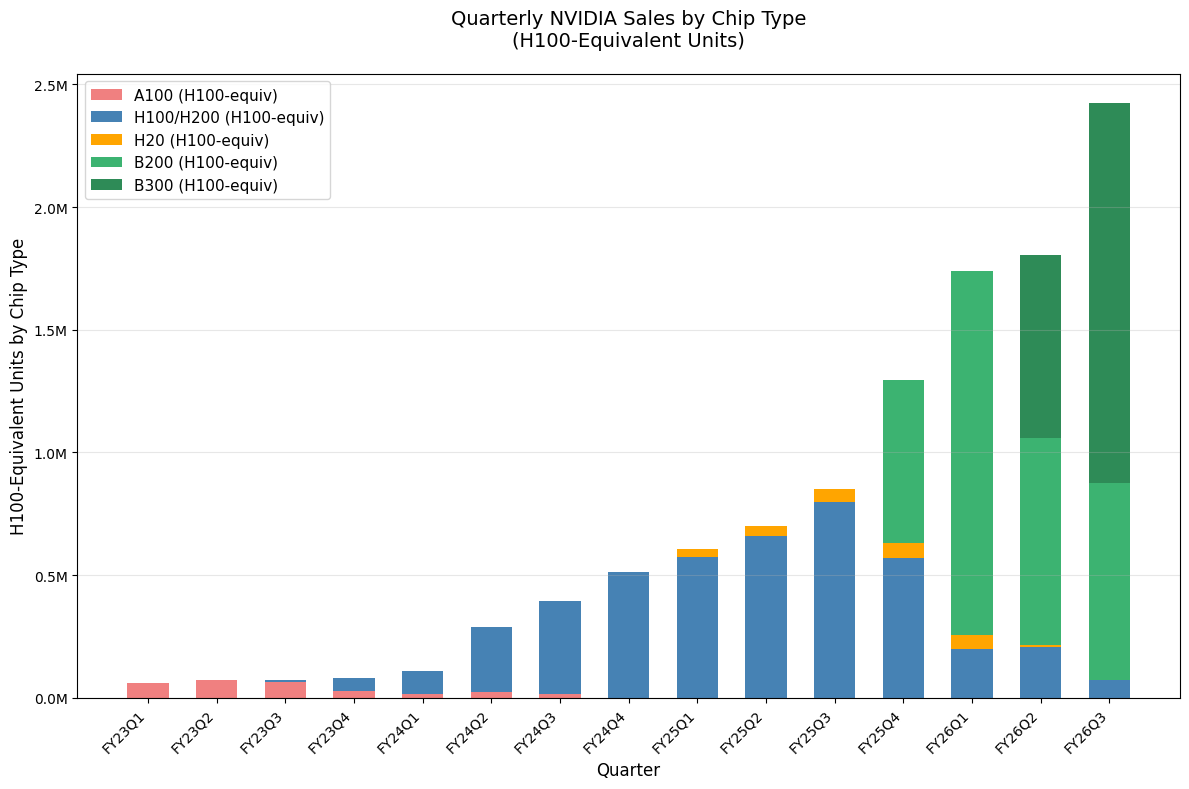

In [17]:
# Visualization: Quarterly Sales by Chip Type (H100-equivalent units)
# ===================================================================

# to do: add error bars (using H100-eq total?)

# Prepare data for quarterly chart
quarters = quarterly_chip_quantities.index.tolist()

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type
bottom = np.zeros(len(quarters))
chip_colors = {'A100': 'lightcoral', 'H100/H200': 'steelblue', 'H20': 'orange', 'B200': 'mediumseagreen', 'B300': 'seagreen'}

for chip in CHIP_TYPES:
    ax.bar(x, chip_data[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=chip_colors[chip])
    bottom += chip_data[chip]

# Add line showing total H100-equivalents per quarter
# totals = quarterly_sales['Total_H100_equiv'].values
# ax2 = ax.twinx()
# ax2.plot(x, totals, 'ko-', linewidth=2, markersize=6, label='Total H100-equiv')
# ax2.set_ylabel('Total H100-Equivalent Units', fontsize=12)
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Formatting
ax.set_ylabel('H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Quarterly NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines1 + lines2, labels1 + labels2, fontsize=11, loc='upper left')
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/quarterly_sales_by_chip.png", dpi=300, bbox_inches="tight")
plt.show()

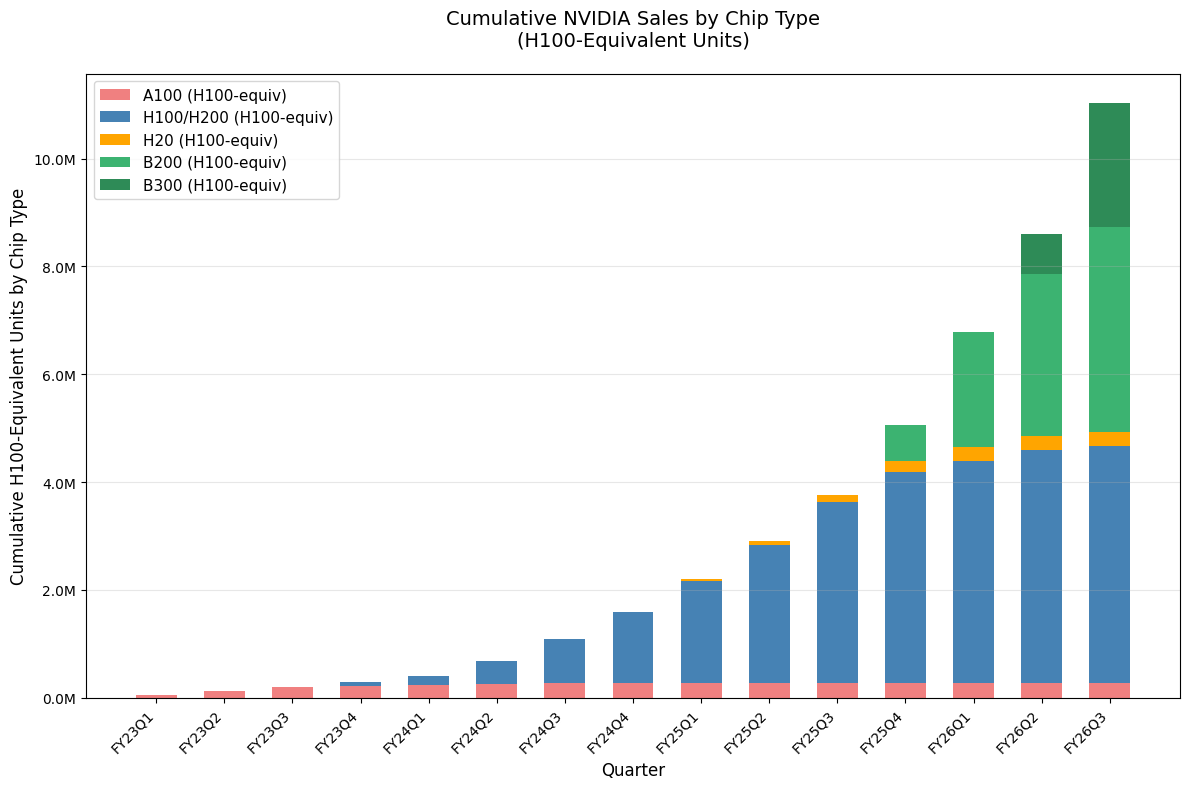

In [18]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
# ============================================================================

# Prepare data for cumulative chart
quarters = quarterly_chip_quantities.index.tolist()

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Calculate cumulative sums for each chip type
chip_data_cumulative = {}
for chip in CHIP_TYPES:
    chip_data_cumulative[chip] = np.cumsum(chip_data[chip])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type (cumulative)
bottom = np.zeros(len(quarters))

for chip in CHIP_TYPES:
    ax.bar(x, chip_data_cumulative[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=chip_colors[chip])
    bottom += chip_data_cumulative[chip]

# Formatting
ax.set_ylabel('Cumulative H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/cumulative_sales_by_chip.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
quarterly_chip_quantities

,decimal_year,A100_quantity_dist,A100_quantity_median,A100_quantity_10th,A100_quantity_25th,A100_quantity_75th,A100_quantity_90th,H100/H200_quantity_dist,H100/H200_quantity_median,H100/H200_quantity_10th,...,B200_quantity_10th,B200_quantity_25th,B200_quantity_75th,B200_quantity_90th,B300_quantity_dist,B300_quantity_median,B300_quantity_10th,B300_quantity_25th,B300_quantity_75th,B300_quantity_90th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,<Distribution> 2810000000.0 * lognorm(lognorm_...,193671.484336,136562.807828,160882.894936,233270.113863,278592.611583,None,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q2,2022.57,<Distribution> 2860000000.0 * lognorm(lognorm_...,226367.054597,187939.791231,205684.347103,250163.272882,275283.054849,None,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q3,2022.82,<Distribution> 2583000000.0 * lognorm(lognorm_...,205168.919657,167484.573153,184905.448179,230175.436722,254123.792280,<Distribution> 287000000.00000006 * lognorm(lo...,9790.992816,7583.724825,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q4,2023.07,<Distribution> 1088000000.0 * lognorm(lognorm_...,85806.945840,70533.867772,77681.364327,96562.939990,105914.248159,<Distribution> 1632000000.0 * lognorm(lognorm_...,55596.819262,42715.766814,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q1,2023.32,<Distribution> 670000000.0 * lognorm(lognorm_m...,53275.451310,43797.663074,47684.984300,59916.334086,65365.945631,<Distribution> 2680000000.0 * lognorm(lognorm_...,91935.973304,71568.105315,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q2,2023.57,<Distribution> 861000000.0 * lognorm(lognorm_m...,68752.183489,55428.890515,61781.078719,75792.573684,84619.732476,<Distribution> 7749000000.0 * lognorm(lognorm_...,268324.462112,208060.946607,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q3,2023.82,<Distribution> 595000000.0000001 * lognorm(log...,47592.772416,38794.111458,42374.697046,52848.613447,58150.071646,<Distribution> 11305000000.0 * lognorm(lognorm...,380815.961553,297998.815346,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q4,2024.07,None,0.000000,0.000000,0.000000,0.000000,0.000000,<Distribution> 15070000000.0 * lognorm(lognorm...,512460.191858,398292.002545,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY25Q1,2024.32,None,0.000000,0.000000,0.000000,0.000000,0.000000,<Distribution> 16524000000.0 * lognorm(lognorm...,572492.740942,441748.692593,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000


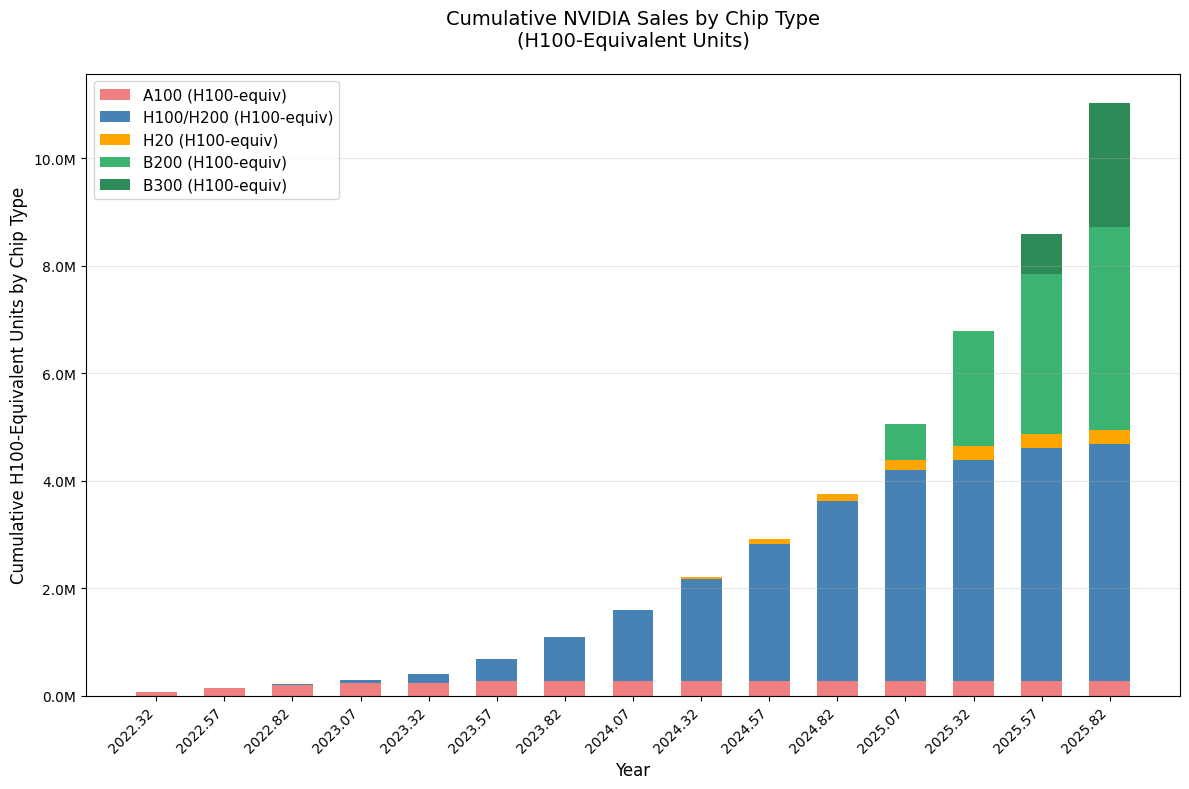

In [20]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
# ============================================================================

# Prepare data for cumulative chart
quarters = quarterly_chip_quantities.index.tolist()
decimal_years = quarterly_chip_quantities['decimal_year'].values

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Calculate cumulative sums for each chip type
chip_data_cumulative = {}
for chip in CHIP_TYPES:
    chip_data_cumulative[chip] = np.cumsum(chip_data[chip])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type (cumulative)
bottom = np.zeros(len(quarters))

for chip in CHIP_TYPES:
    ax.bar(x, chip_data_cumulative[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=chip_colors[chip])
    bottom += chip_data_cumulative[chip]

# Formatting
ax.set_ylabel('Cumulative H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f'{y:.2f}' for y in decimal_years], rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/cumulative_sales_decimal_year.png", dpi=300, bbox_inches="tight")
plt.show()


# Nvidia sales by company

## Aggregate Nvidia sales to Big 4 hyperscalers

In [21]:
# Reset seed
sq.set_seed(42)
np.random.seed(42)

# Company market share estimates (as % of Nvidia's data center revenue)
COMPANY_SHARES = {
    'Microsoft': (0.16, 0.26),
    'Meta': (0.09, 0.14),
    'Alphabet': (0.07, 0.11),
    'Amazon': (0.07, 0.11),
}

# dc_share_of_total_revenue = CHIP_ECONOMICS['dc_share_of_total_revenue']

# Calculate each company's share of Nvidia chips
company_results = {}
company_samples = {}

# Store the squigglepy distributions for subtraction
company_distributions = {}

# US hyperscaler scaling factors
# US companies do not buy H20s, which made up 7% of Nvidia's data center sales
# H20s are only ~1/3 as cost-effective, so US company share of compute-weighted chips should be inflated by 5%
H20_factor = 1.05

# hyperscaler_discount = sq_distribution(0.03, 0.1, lclip = 0)
# hyperscalers likely receive a ~5% discount (relative to overall market average, not relative to small buyers)
# since hyperscalers are ~50% of sales, a 5% discount means their share of units would be ~5% larger than other buyers
# or ~51.2% of units. So an x% discount increases hyperscaler sales by about x/2%
hyperscaler_factor = 1.025

for company, share_range in COMPANY_SHARES.items():
    # Company's share of total Nvidia revenue
    company_share = sq_distribution(*share_range) * H20_factor * hyperscaler_factor

    # Calculate company allocations in H100-equivalent based on their share of datacenter revenue
    # This assumes that hyperscaler customers aren't just buying chips:
    # they are also buying datacenter networking equipment at a similar ratio as the average Nvidia datacenter customer
    company_h100_equivs = company_share * total_h100_equivs
    samples = company_h100_equivs @ 10000

    company_samples[company] = samples
    company_distributions[company] = company_h100_equivs
    company_results[company] = print_percentile_results(samples, f"{company} H100-Equivalents")

# Calculate "Other" category by subtracting each company from total
other_companies = (total_h100_equivs -
                  company_distributions['Microsoft'] -
                  company_distributions['Meta'] -
                  company_distributions['Alphabet'] -
                  company_distributions['Amazon'])

other_samples = other_companies @ 10000
company_samples['Other'] = other_samples
company_results['Other'] = print_percentile_results(other_samples, "Other Companies H100-Equivalents")

Microsoft H100-Equivalents:
  25: 2,021,741
  50: 2,302,293
  75: 2,614,331
Meta H100-Equivalents:
  25: 1,127,585
  50: 1,272,058
  75: 1,427,558
Alphabet H100-Equivalents:
  25: 877,594
  50: 993,627
  75: 1,120,595
Amazon H100-Equivalents:
  25: 875,865
  50: 989,454
  75: 1,118,346
Other Companies H100-Equivalents:
  25: 4,396,196
  50: 4,877,189
  75: 5,336,696


In [22]:
COMPANY_SHARES

{'Microsoft': (0.16, 0.26),
 'Meta': (0.09, 0.14),
 'Alphabet': (0.07, 0.11),
 'Amazon': (0.07, 0.11)}

## Nvidia H100 Equivalents by Company and Quarter

In [23]:
# Reset seed
sq.set_seed(42)
np.random.seed(42)

companies = list(COMPANY_SHARES.keys())
n_samples = 10000

# Initialize results dictionary: company -> quarter -> h100_equivs distribution
company_quarterly_h100_equivs = {company: {} for company in [*companies, 'Other']}

print("Calculating H100-Equivalents by Company and Quarter")
print("=" * 60)

# Iterate through each quarter
for quarter in quarterly_chip_quantities.index:
    print(f"\n{quarter}:")
    
    # Calculate total H100-equivs for this quarter across all chip types
    quarter_total_h100_samples = np.zeros(n_samples)
    
    # For each chip type, sample and convert to H100-equivalents
    chip_distributions = {}
    for chip_type in CHIP_TYPES:
        dist_key = f'{chip_type}_quantity_dist'
        chip_dist = quarterly_chip_quantities.loc[quarter, dist_key]
        
        if chip_dist is not None:
            # Sample from the distribution
            chip_samples = chip_dist @ n_samples
            
            # Convert to H100-equivalents
            h100_equiv_samples = convert_to_h100_equivs(chip_type, chip_samples)
            
            # Store the samples for this chip type
            chip_distributions[chip_type] = h100_equiv_samples
            quarter_total_h100_samples += h100_equiv_samples
        else:
            chip_distributions[chip_type] = np.zeros(n_samples)
    
    # Initialize non-big-4 h100 equivs for this quarter as the overall total
    other_quarter_h100_equivs = chip_distributions['A100'] + chip_distributions['H100/H200'] + chip_distributions['H20'] + chip_distributions['B200'] + chip_distributions['B300']
    
    # Now calculate each company's share
    # To do: there's an issue with sampling shares independently across quarters, leads to the sum of a company's purchases across
    # quarters to be too narrow (because presumably uncertainty in company share is correlated over time)
    for company in companies:
        # Sample company's share of total Nvidia revenue
        company_share = sq_distribution(*COMPANY_SHARES[company]) * hyperscaler_factor
        company_share_samples = company_share @ n_samples
        
        # US companies don't buy H20s, so we redistribute their H20 "share" 
        # to H100s with a cost-effectiveness adjustment
        # H100 is ~6.7x more powerful than H20 while costing ~2x as much,
        # so it is ~3.3x more cost-effective
        if company in ['Microsoft', 'Meta', 'Alphabet', 'Amazon']:
            h20_cost_adjustment = 3.3
            
            company_h100_equivs = (
                company_share_samples * (
                    chip_distributions['A100'] + 
                    chip_distributions['H100/H200'] + 
                    h20_cost_adjustment * chip_distributions['H20'] +
                    chip_distributions['B200'] +
                    chip_distributions['B300']
                )
            )

        # Store results
        company_quarterly_h100_equivs[company][quarter] = company_h100_equivs

        # subtract this company's distribution from the total distribution for the quarter
        other_quarter_h100_equivs = other_quarter_h100_equivs - company_h100_equivs

        print_percentile_results(company_h100_equivs, f"{company} {quarter}")

    print_percentile_results(other_quarter_h100_equivs, f"Other {quarter}")
    company_quarterly_h100_equivs['Other'][quarter] = other_quarter_h100_equivs
    


# Calculate totals by company across all quarters
print("\n" + "=" * 60)
print("Total H100-Equivalents by Company (All Quarters)")
print("=" * 60)

for company in [*companies, 'Other']:
    # Sum across all quarters
    all_quarters_samples = sum(company_quarterly_h100_equivs[company].values())
    print_percentile_results(all_quarters_samples, f"Total H100-equivs for {company}")



Calculating H100-Equivalents by Company and Quarter

FY23Q1:
Microsoft FY23Q1:
  25: 10,180
  50: 12,842
  75: 15,987
Meta FY23Q1:
  25: 5,605
  50: 6,990
  75: 8,674
Alphabet FY23Q1:
  25: 4,388
  50: 5,450
  75: 6,796
Amazon FY23Q1:
  25: 4,371
  50: 5,461
  75: 6,839
Other FY23Q1:
  25: 24,307
  50: 29,575
  75: 35,855

FY23Q2:
Microsoft FY23Q2:
  25: 12,708
  50: 15,076
  75: 17,817
Meta FY23Q2:
  25: 7,030
  50: 8,269
  75: 9,674
Alphabet FY23Q2:
  25: 5,508
  50: 6,450
  75: 7,590
Amazon FY23Q2:
  25: 5,520
  50: 6,484
  75: 7,612
Other FY23Q2:
  25: 30,800
  50: 35,051
  75: 39,855

FY23Q3:
Microsoft FY23Q3:
  25: 13,382
  50: 15,661
  75: 18,349
Meta FY23Q3:
  25: 7,453
  50: 8,623
  75: 10,043
Alphabet FY23Q3:
  25: 5,764
  50: 6,730
  75: 7,847
Amazon FY23Q3:
  25: 5,772
  50: 6,736
  75: 7,848
Other FY23Q3:
  25: 32,263
  50: 36,325
  75: 40,898

FY23Q4:
Microsoft FY23Q4:
  25: 14,953
  50: 17,492
  75: 20,466
Meta FY23Q4:
  25: 8,202
  50: 9,582
  75: 11,171
Alphabet FY23Q4

In [24]:
# Create a summary DataFrame for easier analysis
company_quarterly_summary = []

for company in companies:
    for quarter in quarterly_revenue_df.index:
        if quarter in company_quarterly_h100_equivs[company]:
            samples = company_quarterly_h100_equivs[company][quarter]
            
            start_date = nvda_revenue_df.loc[quarter, 'Start Date']
            end_date = nvda_revenue_df.loc[quarter, 'End Date']
            
            company_quarterly_summary.append({
                'Company': company,
                'Quarter': quarter,
                'Start date': start_date,
                'End date': end_date,
                'decimal_year': fy_to_decimal_year(quarter),
                'h100_equivs_10th': np.percentile(samples, 10),
                'h100_equivs_median': np.percentile(samples, 50),
                'h100_equivs_90th': np.percentile(samples, 90)
            })


company_quarterly_df = pd.DataFrame(company_quarterly_summary)
for col in ['h100_equivs_10th', 'h100_equivs_median', 'h100_equivs_90th']:
    company_quarterly_df[col] = company_quarterly_df[col].round(0).astype(int)
print(company_quarterly_df.head(20))

company_quarterly_df.to_csv('nvidia_quarterly_by_company.csv')

      Company Quarter  Start date    End date  decimal_year  h100_equivs_10th  \
0   Microsoft  FY23Q1  2022-01-31  2022-05-01       2022.32              8257   
1   Microsoft  FY23Q2  2022-05-02  2022-07-31       2022.57             10939   
2   Microsoft  FY23Q3  2022-08-01  2022-10-30       2022.82             11613   
3   Microsoft  FY23Q4  2022-10-31  2023-01-29       2023.07             12919   
4   Microsoft  FY24Q1  2023-01-30  2023-04-30       2023.32             16504   
5   Microsoft  FY24Q2  2023-05-01  2023-07-30       2023.57             42490   
6   Microsoft  FY24Q3  2023-07-31  2023-10-29       2023.82             59109   
7   Microsoft  FY24Q4  2023-10-30  2024-01-28       2024.07             75259   
8   Microsoft  FY25Q1  2024-01-29  2024-04-28       2024.32            102301   
9   Microsoft  FY25Q2  2024-04-29  2024-07-28       2024.57            121036   
10  Microsoft  FY25Q3  2024-07-29  2024-10-27       2024.82            148346   
11  Microsoft  FY25Q4  2024-

## Microsoft time series chart

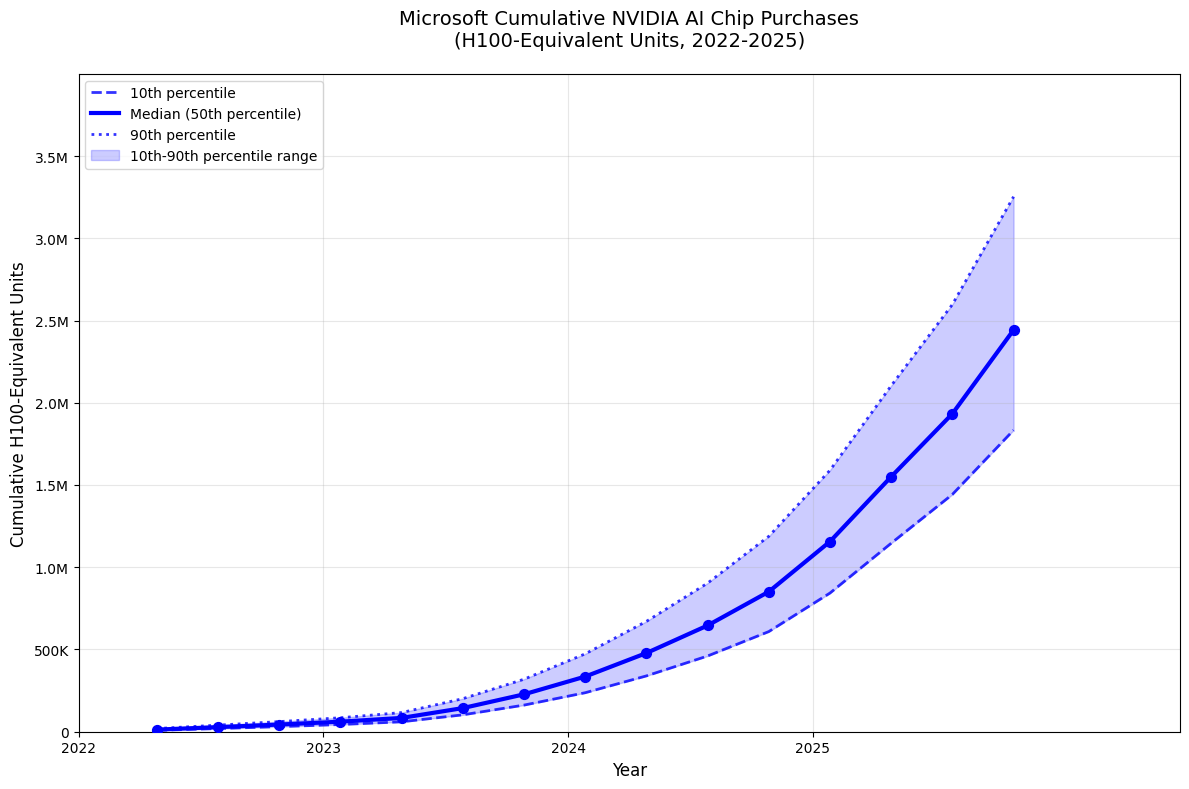

Microsoft H100-equivalent Purchase Timeline:
Quarter         Year     Median Purchase Cumulative Median 10th-90th Range               
FY23Q1          2022.32        12,842       12,842        8,257 -       19,401
FY23Q2          2022.57        15,076       27,918       19,196 -       40,142
FY23Q3          2022.82        15,661       43,579       30,809 -       61,406
FY23Q4          2023.07        17,492       61,071       43,728 -       84,951
FY24Q1          2023.32        22,798       83,869       60,232 -      116,597
FY24Q2          2023.57        59,776      143,645      102,722 -      200,931
FY24Q3          2023.82        83,758      227,403      161,831 -      319,231
FY24Q4          2024.07       107,943      335,346      237,090 -      473,465
FY25Q1          2024.32       142,881      478,227      339,391 -      670,926
FY25Q2          2024.57       167,635      645,862      460,427 -      903,543
FY25Q3          2024.82       205,354      851,216      608,773 -    1,188,

In [25]:
# Microsoft Cumulative Time Series Chart (using new company_quarterly_df)
# ========================================================================

# Filter for Microsoft data only and sort by decimal_year
microsoft_data = company_quarterly_df[company_quarterly_df['Company'] == 'Microsoft'].copy()
microsoft_data = microsoft_data.sort_values('decimal_year')

# Calculate cumulative sums for each percentile
microsoft_data['cumulative_10th'] = microsoft_data['h100_equivs_10th'].cumsum()
microsoft_data['cumulative_median'] = microsoft_data['h100_equivs_median'].cumsum()
microsoft_data['cumulative_90th'] = microsoft_data['h100_equivs_90th'].cumsum()

# Create the time series chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three percentile lines
ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_10th'],
        'b--', linewidth=2, label='10th percentile', alpha=0.8)

ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_median'],
        'b-', linewidth=3, label='Median (50th percentile)')

ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_90th'],
        'b:', linewidth=2, label='90th percentile', alpha=0.8)

# Fill between 25th and 75th percentiles for uncertainty band
ax.fill_between(microsoft_data['decimal_year'],
                microsoft_data['cumulative_10th'],
                microsoft_data['cumulative_90th'],
                alpha=0.2, color='blue', label='10th-90th percentile range')

# Add markers at quarterly points
ax.scatter(microsoft_data['decimal_year'],
           microsoft_data['cumulative_median'],
           s=50, color='blue', zorder=5)

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_title('Microsoft Cumulative NVIDIA AI Chip Purchases\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)

# Format y-axis to show values in thousands/millions
def format_thousands(x, p):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

# Set x-axis to show years nicely
ax.set_xlim(2022, 2026.5)
ax.set_xticks([2022, 2023, 2024, 2025])
ax.set_ylim(0, 3999999)

# Add grid and legend
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig("visualizations/microsoft_cumulative_purchases.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary table
print("Microsoft H100-equivalent Purchase Timeline:")
print("=" * 80)
print(f"{'Quarter':<15} {'Year':<8} {'Median Purchase':<15} {'Cumulative Median':<15} {'10th-90th Range':<30}")
print("=" * 80)
for _, row in microsoft_data.iterrows():
    quarter = row['Quarter']
    year = row['decimal_year']
    median_purchase = row['h100_equivs_median']
    cumulative_10th = row['cumulative_10th']
    cumulative_median = row['cumulative_median']
    cumulative_90th = row['cumulative_90th']
    print(f"{quarter:<15} {year:<8.2f} {median_purchase:>12,.0f} {cumulative_median:>12,.0f} {cumulative_10th:>12,.0f} - {cumulative_90th:>12,.0f}")
print("=" * 80)

In [26]:
microsoft_data.to_csv('microsoft_data.csv')

## CoreWeave, Oracle, and xAI


### CoreWeave

In [27]:
# Reset seed
sq.set_seed(42)
np.random.seed(42)

H100_share_2024 = (0.6, 0.8)
GPU_count_2024 = 250000

COREWEAVE_DATA = {
    # GPU counts from S-1 filing
    'gpus_2024_end': 250_000,

    # GPU mix estimates for installed base at end of 2024
    'hopper_share_2024': (0.6, 0.8),  # 60-80% H100s, rest A100s

    # parameters for estimating data center power of GPUs beyond the 2024 installed base (including hypothetical capacity for GPUs waiting to be installed)
    # 55 MW installed in Q1 and Q2 2025 on average, 72 MW installed per quarter in 2024
    # and CoreWeave's capex is generally ramping up
    'gpu_power_per_quarter': (50, 100),
    # hard variable to name: this represents the number of "quarters' worth" of GPUs CoreWeave has purchased beyond the 2024 installed base.
    # which incorporates uncertainty over the time delay between taking delivery of GPUs and installation in a data center
    'quarters_backlog': (2, 4),

    'h100_datacenter_power_w': (1400, 1700),    # H100 power capacity with PUE overhead
    'NVL72_power_w': (120000, 132000),  # server power rating for NVL72 (72 B200s)
    'NVL72_overhead_factor': (1.1, 1.7),   # PUE overhead (SemiAnalysis estimates 1.35x)
    # the lower end of this range is based on the three Nvidia quarters ending April 2025. The upper is shifted by one quarter
    # REVISIT AFTER NVDA EARNINGS
    'blackwell_share': (0.33, 0.6)
}

n_samples = 10000

# Installed base at end of 2024: 250k GPUs
installed_base = COREWEAVE_DATA['gpus_2024_end']

# Mix of installed base (Hopper vs older generation)
hopper_share_installed = sq_distribution(*COREWEAVE_DATA['hopper_share_2024'], rclip = 1)

# Installed base H100-equivalents
hopper_count = installed_base * hopper_share_installed
a100_count = installed_base * (1 - hopper_share_installed)

# Convert A100s to H100-equivalents (A100 is 312 TFLOPS vs H100's 989 TFLOPS)
a100_h100_equiv = a100_count * (CHIP_FLOPS['A100'] / CHIP_FLOPS['H100/H200'])
installed_base_h100_equiv = hopper_count + a100_h100_equiv

samples = installed_base_h100_equiv @ n_samples

print_percentile_results(samples, "CoreWeave H100-equivs at end of 2024")

gpu_power_per_quarter = sq_distribution(*COREWEAVE_DATA['gpu_power_per_quarter']) * 1e6
quarters_backlog = sq_distribution(*COREWEAVE_DATA['quarters_backlog'])

new_gpu_power_2025 = gpu_power_per_quarter * quarters_backlog

blackwell_share = sq_distribution(*COREWEAVE_DATA['blackwell_share'], lclip = 0, rclip = 1)

h100_dc_power_w = sq_distribution(*COREWEAVE_DATA['h100_datacenter_power_w'])
NVL72_power_w = sq_distribution(*COREWEAVE_DATA['NVL72_power_w'])
NVL72_overhead_factor = sq_distribution(*COREWEAVE_DATA['NVL72_overhead_factor'])

B200_dc_power_w = NVL72_power_w * NVL72_overhead_factor / 72
B200_power_samples = B200_dc_power_w @ n_samples
print_percentile_results(B200_power_samples, "B200 power capacity in a data center (W)")

# Estimate power and GPU count by model. Assumes all non-Blackwell chips in 2025 are H100
blackwell_power_w = new_gpu_power_2025 * blackwell_share
h100_power_w = new_gpu_power_2025 * (1 - blackwell_share)
cw_blackwell_2025 = blackwell_power_w / B200_dc_power_w
cw_hopper_2025 = h100_power_w / h100_dc_power_w

blackwell_h100_equiv = cw_blackwell_2025 * (CHIP_FLOPS['B200'] / CHIP_FLOPS['H100/H200'])
total_coreweave_h100_equiv = installed_base_h100_equiv + cw_hopper_2025 + blackwell_h100_equiv


coreweave_samples = total_coreweave_h100_equiv @ n_samples
print_percentile_results(coreweave_samples, "Total CoreWeave H100-equivs as of July 2025")

CoreWeave H100-equivs at end of 2024:
  25: 183,530
  50: 196,963
  75: 211,216
B200 power capacity in a data center (W):
  25: 2,120
  50: 2,387
  75: 2,686
Total CoreWeave H100-equivs as of July 2025:
  25: 332,069
  50: 370,006
  75: 415,087


{25: 332069, 50: 370006, 75: 415087}

In [28]:
coreweave_samples

array([363532.51463505, 338638.90506223, 495516.9697515 , ...,
       431510.04530493, 467650.45305689, 348984.66070066])

# Integrating CoreWeave and H20 with "Other" bar

In [29]:
other_samples

print_percentile_results(other_samples, "Non-Big 4 hyperscalers")

other_minus_coreweave = other_samples - coreweave_samples

print_percentile_results(other_minus_coreweave, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers:
  25: 4,396,196
  50: 4,877,189
  75: 5,336,696
Non-Big 4 hyperscalers, non-CoreWeave:
  25: 4,016,541
  50: 4,497,088
  75: 4,964,212


{25: 4016541, 50: 4497088, 75: 4964212}

In [30]:
# Shuffle to decorrelate (approximate independence)
np.random.shuffle(other_samples)
np.random.shuffle(coreweave_samples)
other_minus_coreweave_shuffled = other_samples - coreweave_samples

# essentially no difference
print_percentile_results(other_minus_coreweave_shuffled, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers, non-CoreWeave:
  25: 4,017,234
  50: 4,498,270
  75: 4,958,800


{25: 4017234, 50: 4498270, 75: 4958800}

In [31]:
company_results

{'Microsoft': {25: 2021741, 50: 2302293, 75: 2614331},
 'Meta': {25: 1127585, 50: 1272058, 75: 1427558},
 'Alphabet': {25: 877594, 50: 993627, 75: 1120595},
 'Amazon': {25: 875865, 50: 989454, 75: 1118346},
 'Other': {25: 4396196, 50: 4877189, 75: 5336696}}

In [32]:
company_results['CoreWeave'] = print_percentile_results(coreweave_samples, "CoreWeave H100-Equivalents")
company_results['Other'] = print_percentile_results(other_minus_coreweave, f"{company} H100-Equivalents")

CoreWeave H100-Equivalents:
  25: 332,069
  50: 370,006
  75: 415,087
Amazon H100-Equivalents:
  25: 4,016,541
  50: 4,497,088
  75: 4,964,212


In [33]:
other_minus_h20 = other_minus_coreweave - h20_h100_samples
company_results['Other'] = print_percentile_results(other_minus_h20)
company_results['H20'] = print_percentile_results(h20_h100_samples)


Percentiles:
  25: 3,758,796
  50: 4,238,853
  75: 4,701,973
Percentiles:
  25: 252,203
  50: 260,469
  75: 269,222


# Visualizations

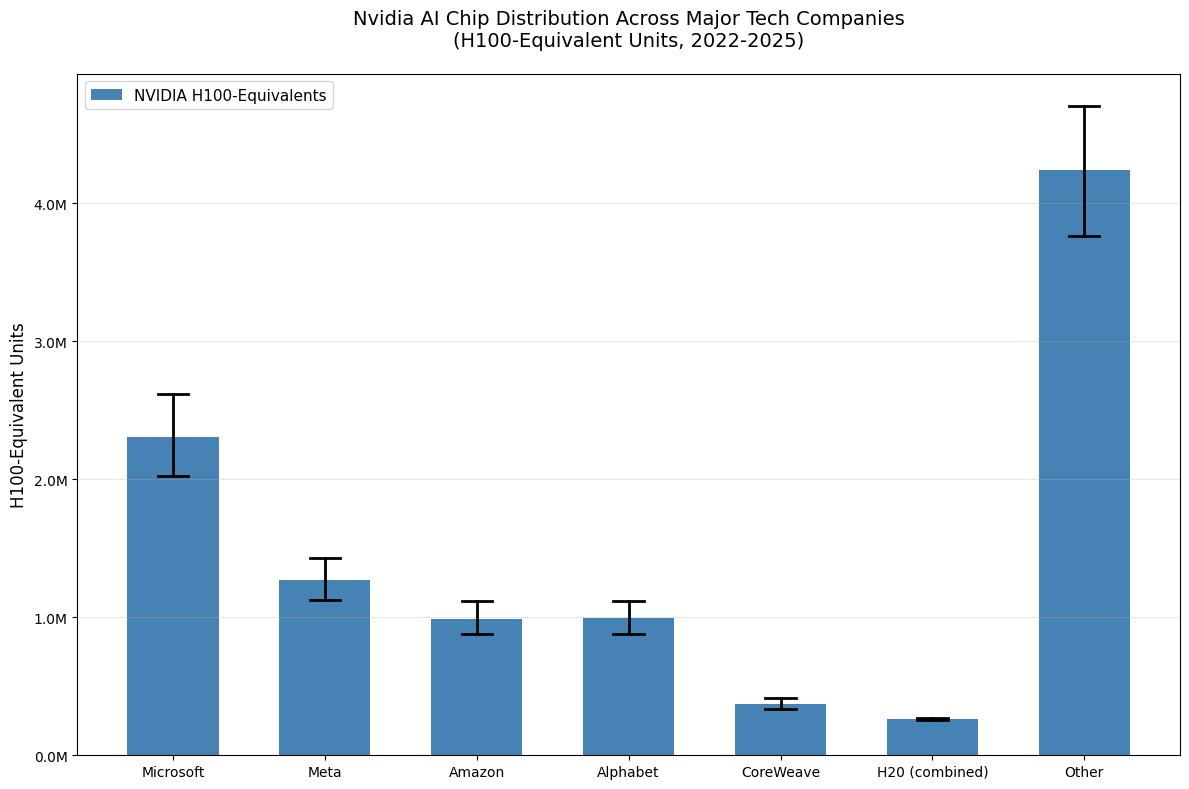


Visualization Notes:
- Error bars show 25th-75th percentile range
- All values converted to H100-equivalent compute units
- Based on NVIDIA revenue FY2023-FY2025 and industry estimates


In [34]:
# version without TPU

# Visualization
# =============

# Prepare data for plotting
companies = [ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20', 'Other']
nvidia_medians = [company_results[company][50] for company in companies]
nvidia_25th = [company_results[company][25] for company in companies]
nvidia_75th = [company_results[company][75] for company in companies]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(companies))
width = 0.6

# Create NVIDIA bars
nvidia_bars = ax.bar(x, nvidia_medians, width, label="NVIDIA H100-Equivalents", color='steelblue')

# Add TPU bar for Alphabet (stacked on NVIDIA)
# alphabet_idx = companies.index('Alphabet')
# tpu_median = tpu_results[50]
# ax.bar(alphabet_idx, tpu_median, width, bottom=nvidia_medians[alphabet_idx],
#        label="TPUs (H100-equiv)", color='orange')

# Add confidence intervals
for i, company in enumerate(companies):
    bar_width = width / 6
    ax.plot([i - bar_width, i + bar_width], [nvidia_25th[i], nvidia_25th[i]], 'k-', linewidth=2)
    ax.plot([i - bar_width, i + bar_width], [nvidia_75th[i], nvidia_75th[i]], 'k-', linewidth=2)
    ax.plot([i, i], [nvidia_25th[i], nvidia_75th[i]], 'k-', linewidth=2)


# Formatting
ax.set_ylabel('H100-Equivalent Units', fontsize=12)
ax.set_title('Nvidia AI Chip Distribution Across Major Tech Companies\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20 (combined)', 'Other'])
ax.legend(fontsize=11)

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("visualizations/company_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nVisualization Notes:")
print("- Error bars show 25th-75th percentile range")
print("- All values converted to H100-equivalent compute units")
print("- Based on NVIDIA revenue FY2023-FY2025 and industry estimates")

# Prepare data for Airtable import

In [ ]:
# Transform data for Airtable
# ============================

# Transform quarterly sales data
quarterly_sales_copy = quarterly_sales.copy()

# Define chip types and their corresponding columns
# H100 is the reference unit, so H100_quantity = H100e value
chip_mappings = [
    ('A100', 'A100_quantity', 'Total_A100_in_H100e', 'Total_A100_in_H100e_10th', 'Total_A100_in_H100e_90th'),
    ('H100', 'H100/H200_quantity', 'Total_H100_in_H100e', 'Total_H100_in_H100e_10th', 'Total_H100_in_H100e_90th'),
    ('H20', 'H20_quantity', 'Total_H20_in_H100e', 'Total_H20_in_H100e_10th', 'Total_H20_in_H100e_90th'),
    ('B200', 'B200_quantity', 'Total_B200_in_H100e', 'Total_B200_in_H100e_10th', 'Total_B200_in_H100e_90th'),
    ('B300', 'B300_quantity', 'Total_B300_in_H100e', 'Total_B300_in_H100e_10th', 'Total_B300_in_H100e_90th'),
]

# Create rows for output
rows = []

for quarter, row in quarterly_sales_copy.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    for chip_type, qty_col, h100e_col, h100e_10th_col, h100e_90th_col in chip_mappings:
        if qty_col in quarterly_sales_copy.columns:
            quantity = row[qty_col]
            h100e_value = row[h100e_col] if h100e_col in quarterly_sales_copy.columns else quantity
            h100e_10th = row[h100e_10th_col] if h100e_10th_col in quarterly_sales_copy.columns else h100e_value
            h100e_90th = row[h100e_90th_col] if h100e_90th_col in quarterly_sales_copy.columns else h100e_value

            # Only include rows where there's actual quantity
            if pd.notna(quantity) and quantity > 0:
                rows.append({
                    'Name': f"{quarter} - {chip_type}",
                    'Compute owner': 'Nvidia',
                    'Designer': 'Nvidia',
                    'Start date': start_date,
                    'End date': end_date,
                    'Compute estimate in H100e (median)': int(h100e_value),
                    'Compute estimate in H100e (10th percentile)': int(h100e_10th),
                    'Compute estimate in H100e (90th percentile)': int(h100e_90th),
                    '# of Units': int(quantity),
                    'Source / Link': '',
                    'Notes': '',
                    'Power estimate (TDP in GW)': '',
                    'Chip type': chip_type,
                    'CI': f"{int(h100e_10th)}-{int(h100e_90th)}",
                    'Last Modified By': '',
                    'Last Modified': '',
                    'Cost estimate (USD)': '',
                    'Select': ''
                })

# Create output dataframe
output_df = pd.DataFrame(rows)

# Save to CSV
output_path = 'quarter_sales_transformed.csv'
output_df.to_csv(output_path, index=False)

print(f"Transformed {len(rows)} rows to quarter_sales_transformed.csv")
print("\nPreview:")
print(output_df[['Name', 'Start date', 'End date', 'Compute estimate in H100e (median)', 'Compute estimate in H100e (10th percentile)', 'Compute estimate in H100e (90th percentile)', 'CI', 'Chip type']].head(10).to_string())

print("\n" + "="*80 + "\n")

# Transform quarterly data by company
quarterly_by_company = company_quarterly_df.copy()

# Create rows for output
rows = []

for _, row in quarterly_by_company.iterrows():
    company = row['Company']
    quarter = row['Quarter']
    start_date = row['Start date']
    end_date = row['End date']
    h100e_median = row['h100_equivs_median']
    h100e_10th = row['h100_equivs_10th']
    h100e_90th = row['h100_equivs_90th']
    
    rows.append({
        'Name': f"{company} - {quarter}",
        'Compute owner': company,
        'Designer': 'Nvidia',
        'Start date': start_date,
        'End date': end_date,
        'Compute estimate in H100e (median)': int(h100e_median),
        'Compute estimate in H100e (10th percentile)': int(h100e_10th),
        'Compute estimate in H100e (90th percentile)': int(h100e_90th),
        'Source / Link': '',
        'Notes': '',
        'Power estimate (TDP in GW)': '',
        'Chip type': 'Nvidia (total)',
        'CI': f"{int(h100e_10th)}-{int(h100e_90th)}",
        'Last Modified By': '',
        'Last Modified': '',
        'Cost estimate (USD)': '',
        'Select': ''
    })

# Create output dataframe
output_df = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_quarterly_by_company_transformed.csv'
output_df.to_csv(output_path, index=False)

print(f"Transformed {len(rows)} rows to nvidia_quarterly_by_company_transformed.csv")
print("\nPreview:")
print(output_df[['Name', 'Compute owner', 'Compute estimate in H100e (median)', 'Compute estimate in H100e (10th percentile)', 'Compute estimate in H100e (90th percentile)', 'CI', 'Chip type']].head(20).to_string())

Transformed 32 rows

Preview:
             Name  Start date    End date  Compute estimate in H100e (median) Chip type
0   FY23Q1 - A100  2022-01-31  2022-05-01                               61098      A100
1   FY23Q2 - A100  2022-05-02  2022-07-31                               71412      A100
2   FY23Q3 - A100  2022-08-01  2022-10-30                               64725      A100
3   FY23Q3 - H100  2022-08-01  2022-10-30                                9791      H100
4   FY23Q4 - A100  2022-10-31  2023-01-29                               27070      A100
5   FY23Q4 - H100  2022-10-31  2023-01-29                               55597      H100
6   FY24Q1 - A100  2023-01-30  2023-04-30                               16807      A100
7   FY24Q1 - H100  2023-01-30  2023-04-30                               91936      H100
8   FY24Q2 - A100  2023-05-01  2023-07-30                               21689      A100
9   FY24Q2 - H100  2023-05-01  2023-07-30                              268324      H100
10